# Drzewa decyzyjne
Łukasz Klimkiewicz, 244822

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
# Numer indeksu
index = 244822

In [59]:
# Wartości pochodne
seed = index
n_samples = int(str(index)[0:2] + str(index)[-2:])
print(f'seed: {seed}; samples: {n_samples}')

seed: 244822; samples: 2422


## Implementacja drzewa decyzyjnego

In [60]:
class Tree:
    
    def __init__(self, classifier, X, y, depth=0):
        assert y.size > 0
        self.classifier = classifier
        self.X = X
        self.y = y
        self.depth = depth
        
        self.samples = X.shape[0]
        self.values = self._get_values(y)
        self.class_ = np.argmax(self.values)
        self.entropy = self._calc_entropy(y)
        
        self.feature = None
        self.treshold = None
        
        self.left = None
        self.right = None
        
    @staticmethod
    def _get_values(y):
        count_0 = np.sum(y == 0)
        count_1 = np.sum(y == 1)
        return np.array([count_0, count_1])
    
    @classmethod
    def _calc_entropy(cls, y):
        if y.size == 0:
            return 0
        values = cls._get_values(y)
        p = values / np.sum(values)
        p_log_p = p * np.log(p, where=p > 0)
        H = - np.sum(p_log_p)
        return H
    
    @property
    def _decision_node(self):
        return self.left is not None
    
    def _get_proper_subtree(self, x):
        res = np.less_equal(x[self.feature], self.treshold)
        subtree = self.left if res else self.right
        return subtree
    
    def expand(self):
        assert not self._decision_node, 'Node is already expanded'
        assert self.samples > 1
        feature, treshold = self._get_best_split_feature_and_treshold()
        self._split(feature, treshold)
        return self.left, self.right
    
    def _get_best_split_feature_and_treshold(self):
        n_features = self.X.shape[1]
        features = np.arange(n_features)
        tresholds_and_gains = np.array([self._get_best_split_treshold(feature) for feature in features])
        tresholds = tresholds_and_gains[:, 0]
        gains = tresholds_and_gains[:, 1]
        best_index = np.argmax(gains)
        return features[best_index], tresholds[best_index]
    
    def _get_best_split_treshold(self, feature):
        feature_values = self.X[:, feature]
        if feature_values.size > self.classifier.resolution:
            percentiles = np.linspace(0, 100, self.classifier.resolution, endpoint=False)
            tresholds = np.percentile(feature_values, percentiles)
        else:
            tresholds = feature_values
        gains = np.array([self._get_split_gain(feature, treshold) for treshold in tresholds])
        best_index = np.argmax(gains)
        return tresholds[best_index], gains[best_index]
    
    def _get_split_gain(self, feature, treshold):
        op_filter = np.less_equal(self.X[:, feature], treshold)
        y1, y2 = self.y[op_filter], self.y[~op_filter]
        s1, s2 = y1.size, y2.size
        s = self.y.size
        e1, e2 = self._calc_entropy(y1), self._calc_entropy(y2)
        return self.entropy - (s1/s*e1 + s2/s*e2)
    
    def _split(self, feature, treshold):
        assert self.samples >= 0
        op_result = np.less_equal(self.X[:, feature], treshold)
        count_0 = np.sum(op_result == 0)
        count_1 = np.sum(op_result == 1)
        assert count_0 > 0 and count_1 > 0, f'{self.values} | {count_0} {count_1}, {self.X[:, feature]}'
        sorted_indexes = np.argsort(op_result)
        
        np.take(self.y, sorted_indexes, out=self.y)
        np.take(self.X, sorted_indexes, axis=0, out=self.X)
        
        lt = Tree(self.classifier, self.X[count_0:], self.y[count_0:], depth=self.depth+1)
        rt = Tree(self.classifier, self.X[:count_0], self.y[:count_0], depth=self.depth+1)
        
        self.left = lt
        self.right = rt
        self.feature = feature
        self.treshold = treshold
        
        return lt, rt
        
    def predict(self, x):
        if self._decision_node:
            subtree = self._get_proper_subtree(x)
            return subtree.predict(x)
        else:
            return self.class_
        
    def predict_proba(self, x):
        if self._decision_node:
            subtree = self._get_proper_subtree(x)
            return subtree.predict_proba(x)
        else:
            return self.values / np.sum(self.values)

In [61]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from scipy.sparse import issparse


class CustomDecisionTreeClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, max_depth=None, resolution=100):
        self.max_depth = max_depth
        self.resolution = resolution
        self._tree = None

    def fit(self, X, y):
        # preparing inputs
        y = y.flatten()
        if issparse(X):
            X = X.A

        # single node tree
        tree = Tree(self, X.copy(), y.copy())
        
        # expanding tree with bfs
        nodes = [tree]
        while nodes:
            node = nodes.pop(0)
            
            if self.max_depth and node.depth >= self.max_depth or node.samples <= 1 or node.entropy == 0:
                continue
                
            childs = node.expand()
            nodes.extend(childs)
            
        self._tree = tree
        return self

    def predict(self, X):
        if self._tree is None:
            raise ValueError('Model is not fitted')
        y = np.array([self._tree.predict(x) for x in X])
        return y
    
    def predict_proba(self, X):
        if self._tree is None:
            raise ValueError('Model is not fitted')
        y = np.array([self._tree.predict_proba(x) for x in X])
        return y

### Funkcje pomocnicze

In [62]:
def plot_classifier(classifier, X, y, *, ax, margin=0.2, resolution=100, 
                    title='Powierzchnia decyzyjna', xl='Cecha 1', yl='Cecha 2'):
    
    data = {'x': X, 'y': y}

    x1 = data['x'][:,0].min() - margin
    x2 = data['x'][:,0].max() + margin
    y1 = data['x'][:,1].min() - margin
    y2 = data['x'][:,1].max() + margin

    space_syn1 = np.meshgrid(np.linspace(x1, x2, resolution), np.linspace(y1, y2, resolution))
    predictions_syn1 = classifier.predict(np.dstack([*space_syn1]).reshape(-1, 2)).reshape(resolution, resolution)

    ax.contourf(space_syn1[0], space_syn1[1], predictions_syn1, alpha=0.2)
    ax.scatter(data['x'][:,0], data['x'][:,1], c=data['y']);

    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    ax.set_title(title);
    ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
    ax.grid()

In [63]:
from sklearn.base import clone
import timeit

def measure_models_times(models, data, n_fit=10, n_predict=100):
    records = []
    
    for name, model in models.items():
        cloned_model = clone(model)

        def time_fit():
            cloned_model.fit(data['train']['x'], data['train']['y'])

        def time_predict():
            cloned_model.predict(data['test']['x'])

        fit_time = timeit.timeit(time_fit, number=n_fit) / n_fit
        predict_time = timeit.timeit(time_predict, number=n_predict) / n_predict

        record = (name, fit_time, predict_time)
        records.append(record)
        
    matrix = np.array(records)

    df = pd.DataFrame({
        'Name': matrix[:,0],
        'Fit time': matrix[:,1],
        'Predict time': matrix[:,2],
    })
    
    df = df.set_index(['Name']).sort_index().rename_axis(index=None)
    return df

## Część I

### Generowanie danych

In [64]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier

# Generowanie
syn1_x, syn1_y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, 
                                     n_repeated=0, n_clusters_per_class=1, random_state=seed, class_sep=1)

# Podział na zbiory
syn1_train_x, syn1_test_x, syn1_train_y, syn1_test_y = train_test_split(
    syn1_x, syn1_y, test_size=.2, random_state=seed, stratify=syn1_y)

# Strukturyzacja
syn1_data = {
    'train': {
        'x': syn1_train_x,
        'y': syn1_train_y
    },
    'test': {
        'x': syn1_test_x,
        'y': syn1_test_y
    }
}

In [65]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Generowanie
syn2_x, syn2_y = make_moons(n_samples=n_samples, noise=0.1, random_state=seed)

# Podział na zbiory
syn2_train_x, syn2_test_x, syn2_train_y, syn2_test_y = train_test_split(syn2_x, syn2_y, test_size=.2, random_state=seed)

# Strukturyzacja
syn2_data = {
    'train': {
        'x': syn2_train_x,
        'y': syn2_train_y,
    },
    'test': {
        'x': syn2_test_x,
        'y': syn2_test_y,
    }
}

In [66]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier

# Generowanie
syn3_x, syn3_y = make_classification(n_samples=n_samples, n_features=4, n_informative=4, n_redundant=0, 
                                     n_repeated=0, n_clusters_per_class=5, random_state=seed,
                                     class_sep=13, hypercube=False)

syn3_x = syn3_x[:, :2]

# Podział na zbiory
syn3_train_x, syn3_test_x, syn3_train_y, syn3_test_y = train_test_split(
    syn3_x, syn3_y, test_size=.2, random_state=seed, stratify=syn3_y)

# Strukturyzacja
syn3_data = {
    'train': {
        'x': syn3_train_x,
        'y': syn3_train_y
    },
    'test': {
        'x': syn3_test_x,
        'y': syn3_test_y
    }
}

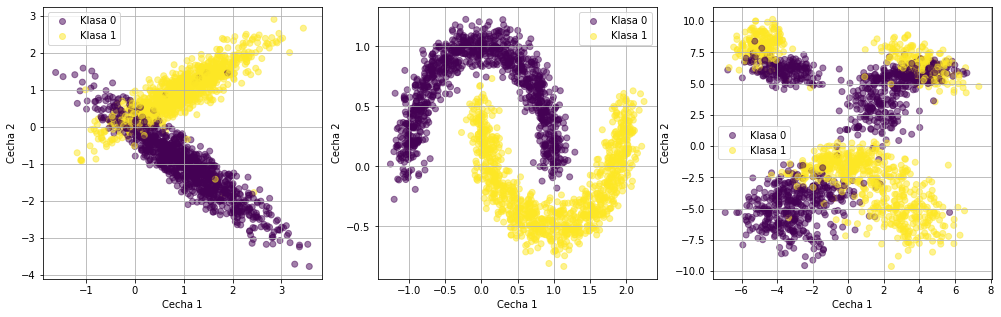

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

for ax, data in zip(axs, [syn1_data, syn2_data, syn3_data]):
    scatter = ax.scatter(data['train']['x'][:,0], data['train']['x'][:,1], c=data['train']['y'], alpha=0.5)
    ax.set_xlabel('Cecha 1')
    ax.set_ylabel('Cecha 2')
    ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
    ax.grid()

### Funkcje pomocnicze

In [105]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

def train_classifiers(data, depths, c_resolution=100):
    
    models = {}

    for depth in depths:

        depth_models = {}
        models[depth] = depth_models

        custom_model = CustomDecisionTreeClassifier(max_depth=depth, resolution=c_resolution)

        scikit_model = DecisionTreeClassifier(max_depth=depth, criterion='entropy')

        custom_model.fit(data['train']['x'], data['train']['y'])
        scikit_model.fit(data['train']['x'], data['train']['y'])

        depth_models['custom'] = custom_model
        depth_models['scikit'] = scikit_model
        
    return models

In [69]:
def plot_classifiers(models, data):
    n_depths = len(models)
    
    fig, axs = plt.subplots(n_depths, 2, figsize=(15, 6*n_depths))

    for y, depth in enumerate(models):
        depth_models = models[depth]
        for x, model in enumerate(depth_models.values()):
            ax = axs[y][x]
            plot_classifier(model, data['x'], data['y'], ax=ax, title=None, xl=None, yl=None)
    
    for i, depth in enumerate(models.keys()):
        axs[i][0].set_ylabel(f'Depth = {depth}', fontsize=15)
        
    axs[0, 0].set_title('Custom', fontsize=15)
    axs[0, 1].set_title('Scikit', fontsize=15)

In [70]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrixes(models, data):
    n_depths = len(models)
    fig, axs = plt.subplots(n_depths, 2, figsize=(7, 3*n_depths))

    for y, item in enumerate(models.items()):
        depth, depth_models = item
        
        ConfusionMatrixDisplay.from_estimator(depth_models['custom'], data['x'], data['y'], ax=axs[y, 0])
        ConfusionMatrixDisplay.from_estimator(depth_models['scikit'], data['x'], data['y'], ax=axs[y, 1])
        
        axs[y, 0].set_title(f'Custom (depth = {depth})')
        axs[y, 1].set_title(f'Scikit (depth = {depth})')
        
    fig.tight_layout()

In [71]:
from sklearn.metrics import recall_score, f1_score

def show_models_metrics(models, data):
    records = []
    
    for depth, depth_models in models.items():
        for method, model in depth_models.items():
            
            predictions = model.predict(data['x'])

            sens = recall_score(data['y'], predictions)
            spec = recall_score(data['y'], predictions, pos_label=0)
            f1 = f1_score(data['y'], predictions)
            
            record = (depth, method, sens, spec, f1)
            records.append(record)
            
    matrix = np.array(records)

    df = pd.DataFrame({
        'Depth': matrix[:,0],
        'Method': matrix[:,1],
        'Sensitivity': matrix[:,2],
        'Specificity': matrix[:,3],
        'F1': matrix[:,4], 
    })
    
    df = df.set_index(['Method', 'Depth']).sort_index()
    
    return df

In [72]:
from sklearn.metrics import RocCurveDisplay

def show_roc_curves(models, data):
    n_depths = len(models)
    fig, axs = plt.subplots(n_depths, 2, figsize=(11, 4*n_depths))

    for y, item in enumerate(models.items()):
        depth, depth_models = item
        
        predictions_c = depth_models['custom'].predict_proba(data['x'])[:, 1]
        predictions_s = depth_models['scikit'].predict_proba(data['x'])[:, 1]

        RocCurveDisplay.from_predictions(data['y'], predictions_c, ax=axs[y, 0])
        RocCurveDisplay.from_predictions(data['y'], predictions_s, ax=axs[y, 1])
        
        axs[y, 0].set_title(f'Custom (depth = {depth})')
        axs[y, 1].set_title(f'Scikit (depth = {depth})')
        
        axs[y, 0].grid()
        axs[y, 1].grid()
        
    fig.tight_layout()

In [73]:
from sklearn.base import clone
import timeit

def measure_times(models, data, n_fit=10, n_predict=100):
    records = []
    
    for depth, depth_models in models.items():
        for method, model in depth_models.items():
            cloned_model = clone(model)
            
            def time_fit():
                cloned_model.fit(data['train']['x'], data['train']['y'])

            def time_predict():
                cloned_model.predict(data['test']['x'])
        
            fit_time = timeit.timeit(time_fit, number=n_fit) / n_fit
            predict_time = timeit.timeit(time_predict, number=n_predict) / n_predict

            record = (depth, method, fit_time, predict_time)
            records.append(record)
        
    matrix = np.array(records)

    df = pd.DataFrame({
        'Depth': matrix[:,0],
        'Method': matrix[:,1],
        'Fit time': matrix[:,2],
        'Predict time': matrix[:,3],
    })
    
    df = df.set_index(['Method', 'Depth']).sort_index()
    return df

### a) Pierwszy zbiór jednomodowy

#### Nauka

In [106]:
models_1 = train_classifiers(syn1_data, depths=[None, 2], c_resolution=200)

#### Powierzchnie decyzyjne

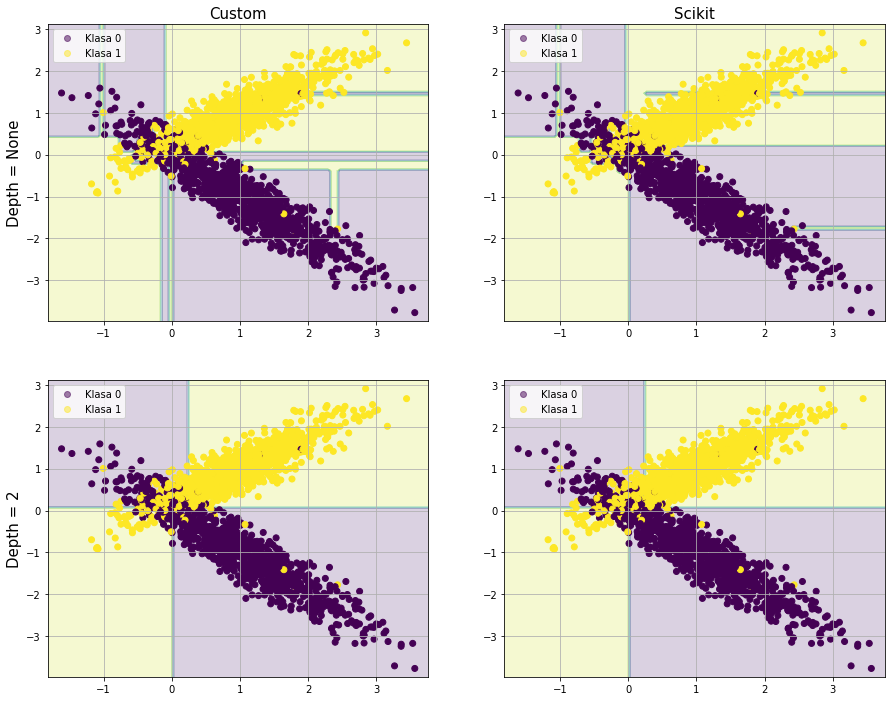

In [107]:
plot_classifiers(models_1, syn1_data['train'])

#### Macierz przekłamań

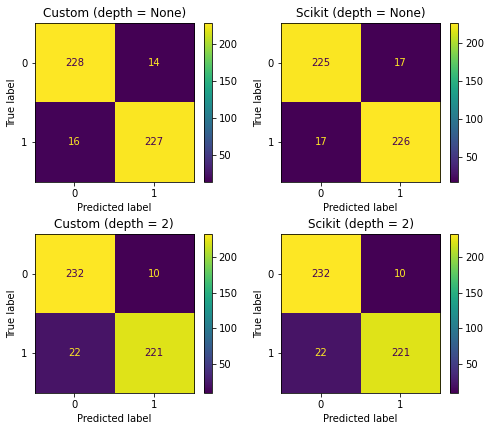

In [108]:
plot_confusion_matrixes(models_1, syn1_data['test'])

#### Metryki

In [109]:
show_models_metrics(models_1, syn1_data['test'])

Sensitivity Specificity        F1
Method Depth                                  
custom 2        0.909465    0.958678  0.932489
       NaN      0.934156    0.942149  0.938017
scikit 2        0.909465    0.958678  0.932489
       NaN      0.930041    0.929752  0.930041

#### Krzywa ROC

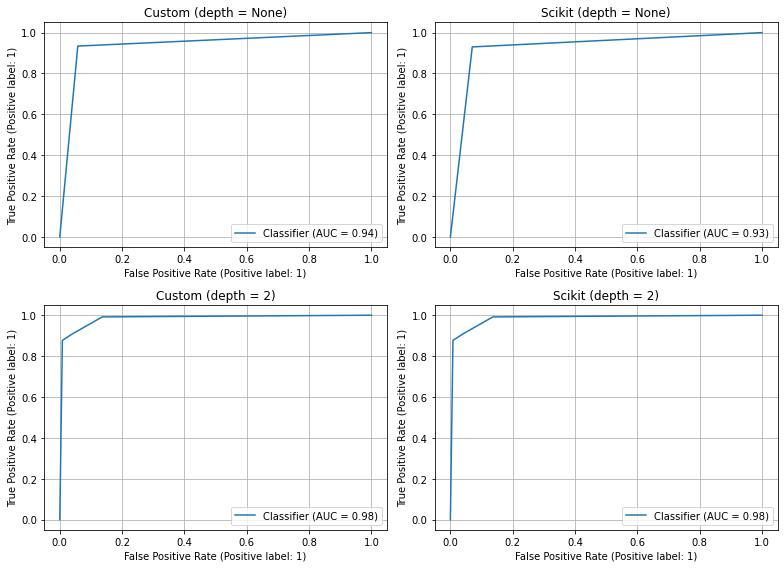

In [110]:
show_roc_curves(models_1, syn1_data['test'])

#### Czasy

In [111]:
measure_times(models_1, syn1_data, n_fit=2, n_predict=100)

Fit time Predict time
Method Depth                       
custom 2      0.080993      0.00213
       NaN    0.608299     0.006471
scikit 2      0.001339     0.000053
       NaN    0.003592      0.00006

### b) Drugi zbiór - moons

#### Nauka

In [112]:
models_2 = train_classifiers(syn2_data, depths=[None, 2])

#### Powierzchnie decyzyjne

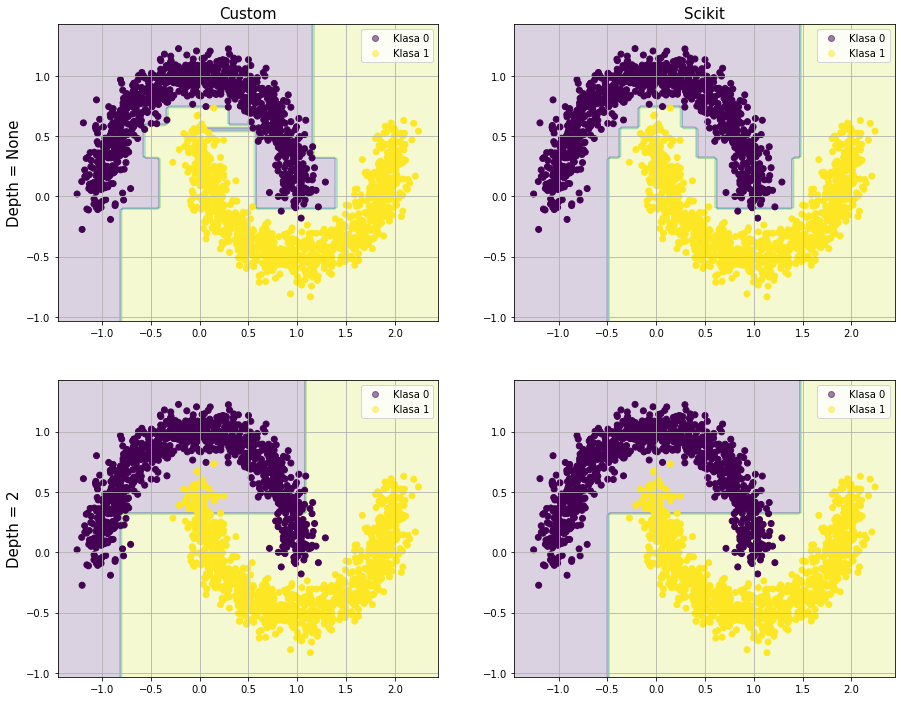

In [113]:
plot_classifiers(models_2, syn2_data['train'])

#### Macierz przekłamań

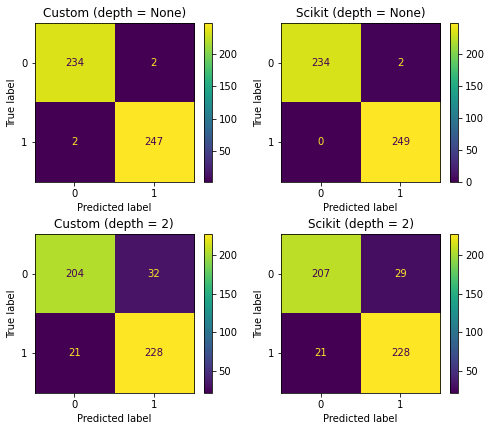

In [114]:
plot_confusion_matrixes(models_2, syn2_data['test'])

#### Metryki

In [115]:
show_models_metrics(models_2, syn2_data['test'])

Sensitivity Specificity        F1
Method Depth                                  
custom 2        0.915663    0.864407  0.895874
       NaN      0.991968    0.991525  0.991968
scikit 2        0.915663    0.877119  0.901186
       NaN           1.0    0.991525     0.996

#### Krzywa ROC

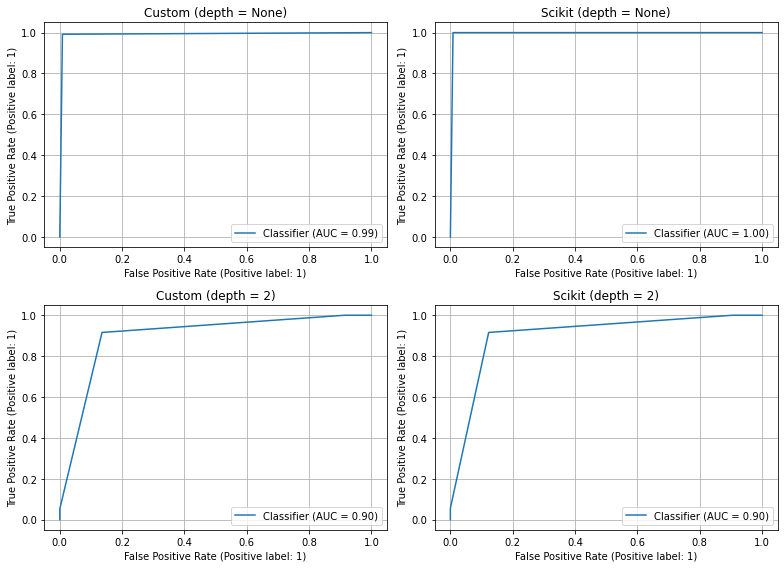

In [116]:
show_roc_curves(models_2, syn2_data['test'])

#### Czasy

In [117]:
measure_times(models_2, syn2_data)

Fit time Predict time
Method Depth                       
custom 2      0.042649      0.00217
       NaN    0.201082     0.004614
scikit 2      0.001215     0.000053
       NaN    0.002227     0.000055

### c) Trzeci zbiór - wielomodowy

#### Nauka

In [118]:
models_3 = train_classifiers(syn3_data, depths=[None, 10, 2])

#### Powierzchnie decyzyjne

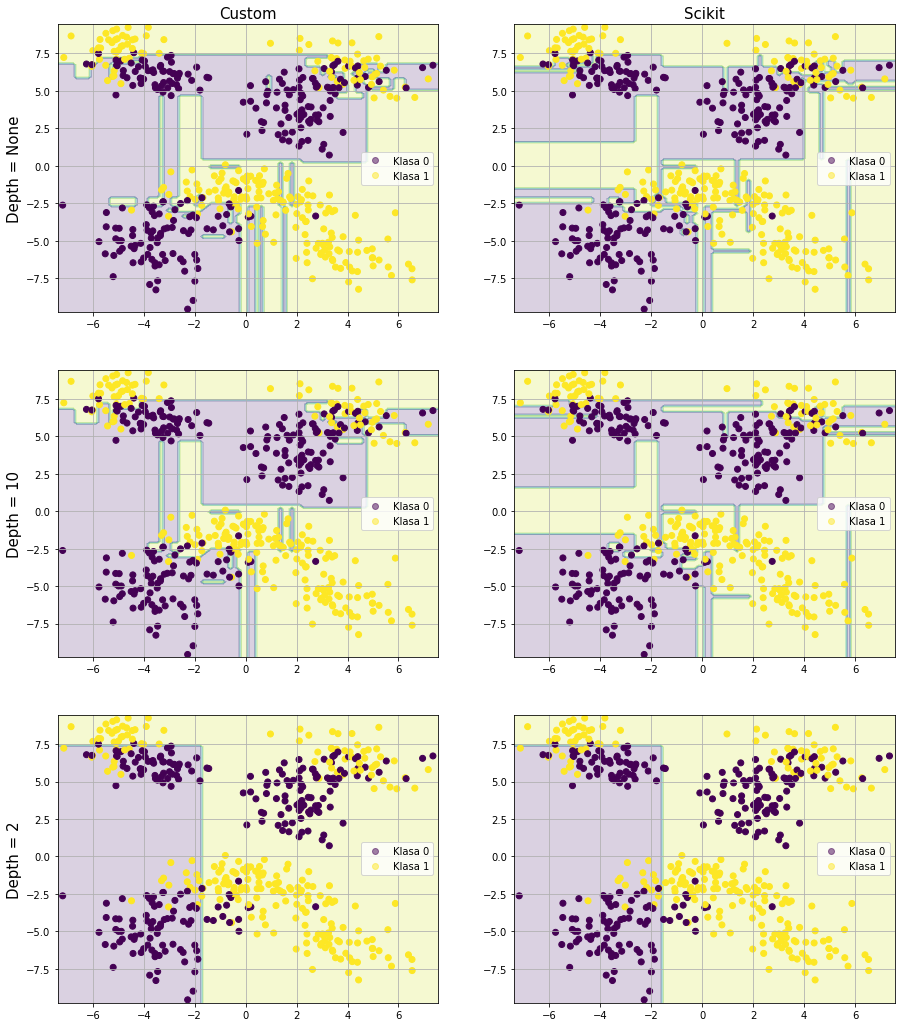

In [119]:
plot_classifiers(models_3, syn3_data['test'])

#### Macierz przekłamań

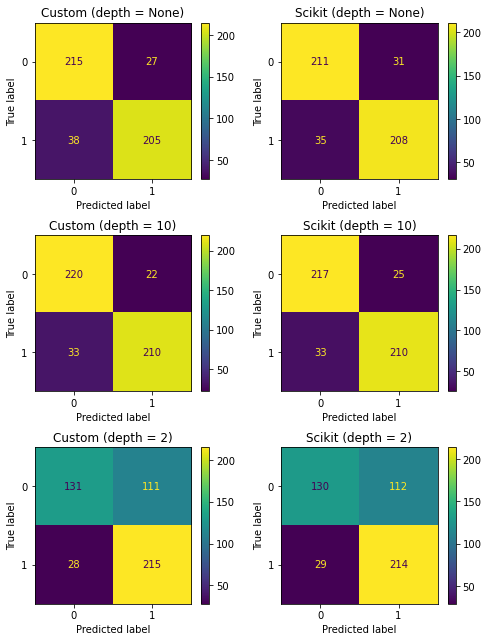

In [120]:
plot_confusion_matrixes(models_3, syn3_data['test'])

#### Metryki

In [121]:
show_models_metrics(models_3, syn3_data['test'])

Sensitivity Specificity        F1
Method Depth                                  
custom 2        0.884774    0.541322  0.755712
       10       0.864198    0.909091  0.884211
       NaN      0.843621     0.88843  0.863158
scikit 2        0.880658     0.53719  0.752197
       10       0.864198    0.896694  0.878661
       NaN      0.855967    0.871901  0.863071

#### Krzywa ROC

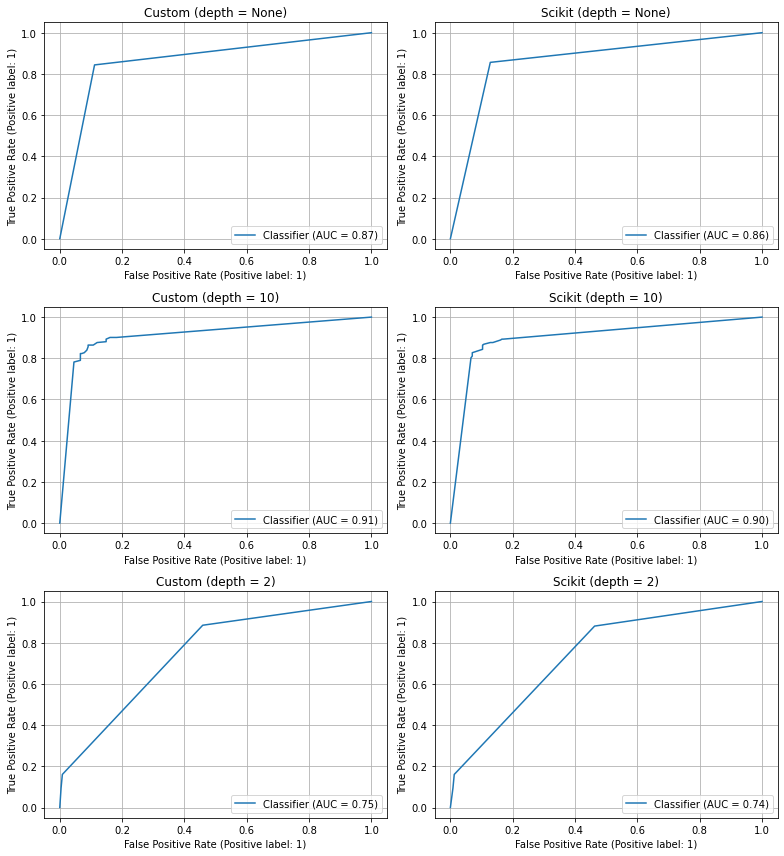

In [122]:
show_roc_curves(models_3, syn3_data['test'])

#### Czasy

In [123]:
measure_times(models_3, syn3_data, n_fit=5, n_predict=100)

Fit time Predict time
Method Depth                       
custom 2      0.042051     0.002096
       10     0.621679     0.007061
       NaN    0.744105      0.00749
scikit 2      0.001277     0.000053
       10     0.003484     0.000059
       NaN    0.003696      0.00006

## Część II

### Przygotowanie danych

In [124]:
# Wczytywanie
column_names = ['profile_mean', 'profile_stdev', 'profile_skewness', 'profile_kurtosis', 
                'dm_mean', 'dm_stdev', 'dm_skewness', 'dm_kurtosis', 'class']
htru_raw_data = pd.read_csv('HTRU_2.csv', names=column_names)

In [125]:
# Sprawdzenie brakujących wartości
htru_raw_data.isna().sum()

profile_mean        0
profile_stdev       0
profile_skewness    0
profile_kurtosis    0
dm_mean             0
dm_stdev            0
dm_skewness         0
dm_kurtosis         0
class               0
dtype: int64

In [126]:
# Oddzielenie kolumn
htru_x = htru_raw_data.drop(columns=['class'])
htru_y = htru_raw_data['class'].to_numpy()

In [127]:
# Podział na zbiory
train_x, test_x, train_y, test_y = train_test_split(
    htru_x, htru_y,
    test_size=.2,
    random_state=seed,
    stratify=htru_y,
)

# Strukturyzacja
htru = {
    'train': {
        'x': train_x,
        'y': train_y,
    },
    'test': {
        'x': test_x,
        'y': test_y,
    }
}

### Nauka

In [128]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from time import time

htru_model = DecisionTreeClassifier(random_state=seed)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 20),
    'min_samples_split': np.arange(2, 50, 5).astype(np.int_),
    'min_samples_leaf': np.arange(1, 10).astype(np.int_),
}

search = GridSearchCV(htru_model, param_grid, cv=3, n_jobs=-1, verbose=1)

start = time()
search.fit(htru['train']['x'], htru['train']['y']);
print('Fit time:', time()-start)

Fitting 3 folds for each of 3420 candidates, totalling 10260 fits
Fit time: 90.82831358909607


In [129]:
search.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 8,
 'min_samples_split': 22}

#### Macierz przekłamań

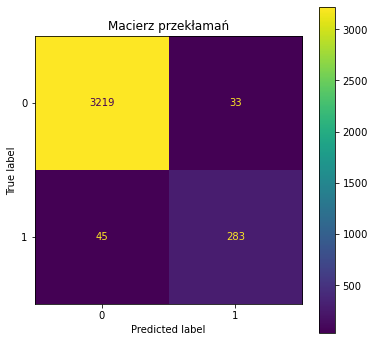

In [130]:
from sklearn.metrics import ConfusionMatrixDisplay

data = htru['test']
fig, ax = plt.subplots(figsize=(6, 6))

ConfusionMatrixDisplay.from_estimator(search, data['x'], data['y'], ax=ax)
ax.set_title('Macierz przekłamań');

#### Metryki

In [131]:
from sklearn.metrics import recall_score, f1_score

# Obliczanie metryk
data = htru['test']

predictions = search.predict(data['x'])

sens = recall_score(data['y'], predictions)
spec = recall_score(data['y'], predictions, pos_label=0)
f1 = f1_score(data['y'], predictions)

# Tworzenie tabeli
pd.DataFrame({'Sensitivity': [sens], 'Specificity': [spec], 'F1': [f1]}, index=['Classifier'])

,Sensitivity,Specificity,F1
Classifier,0.862805,0.989852,0.878882


#### Krzywa ROC

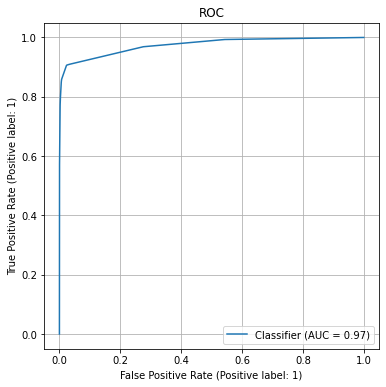

In [132]:
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_predict

data = htru['train']
fig, ax = plt.subplots(figsize=(6, 6))

predictions_c = search.predict_proba(data['x'])[:, 1]
RocCurveDisplay.from_predictions(data['y'], predictions_c, ax=ax)
ax.set_title('ROC')
ax.grid();

#### Czasy

In [133]:
measure_models_times({'model': htru_model}, data=htru, n_fit=10, n_predict=100)

,Fit time,Predict time
model,0.11468711000052281,0.0009634079999523237


## Część III

### Zbieranie pomiarów

In [134]:
from sklearn.base import clone
from time import time
from sklearn.metrics import recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline


def get_measures_for_model_and_depth(model, depth, repeats=10):
    
    data = htru
    
    fit_time_list = []
    predict_time_list = []
    sens_list = []
    spec_list = []
    f1_list = []
    
    for i in range(repeats):
        cloned_model = clone(model)
        cloned_model[-1].max_depth = depth
        
        fit_start = time()
        cloned_model.fit(htru['train']['x'], htru['train']['y'])
        fit_time = time() - fit_start

        predict_start = time()
        predictions = cloned_model.predict(data['test']['x'])
        predict_time = time() - predict_start

        sens = recall_score(data['test']['y'], predictions)
        spec = recall_score(data['test']['y'], predictions, pos_label=0)
        f1 = f1_score(data['test']['y'], predictions)
        
        fit_time_list.append(fit_time)
        predict_time_list.append(predict_time)
        sens_list.append(sens)
        spec_list.append(spec)
        f1_list.append(f1)
        
        print('*', end='')

    fit_time = np.mean(fit_time_list)
    predict_time = np.mean(predict_time_list)
    sens = np.mean(sens_list)
    spec = np.mean(spec_list)
    f1 = np.mean(f1_list)
    
    return {'fit': fit_time, 'predict': predict_time, 'sens': sens, 'spec': spec, 'f1': f1}


def get_measures_for_depth(depth, repeats, c_resolution):
    
    custom_model = CustomDecisionTreeClassifier(resolution=c_resolution)
    scikit_model = DecisionTreeClassifier(criterion='entropy')
    
    custom_measures = get_measures_for_model_and_depth(custom_model, depth, repeats)
    scikit_measures = get_measures_for_model_and_depth(scikit_model, depth, repeats)
    
    return {'custom': custom_measures, 'scikit': scikit_measures}


def get_measures(depths, repeats, c_resolution=100):
    print('_' * len(depths) * repeats * 2)
    measures = {depth: get_measures_for_depth(depth, repeats, c_resolution) for depth in depths}
    print()
    return measures

In [48]:
from time import time
measure_start = time()
measures = get_measures(depths=range(1, 21), repeats=10)
measure_time = time() - measure_start
print(f'Measure time: {measure_time / 60} minutes')

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************
Measure time: 16.729023508230846 minutes


### Tabela wyników

In [49]:
records = []

for depth, depth_values in measures.items():
    for method, single_measure in depth_values.items():
        record_measures = (single_measure[key] for key in ('fit', 'predict', 'sens', 'spec', 'f1'))
        record = (depth, method, *record_measures)
        records.append(record)

matrix = np.array(records)

df = pd.DataFrame({
    'Depth': matrix[:,0],
    'Method': matrix[:,1],
    'Fit time': matrix[:,2],
    'Predict time': matrix[:,3],
    'Sensitivity': matrix[:,4],
    'Specificity': matrix[:,5],
    'F1': matrix[:,6],
})

df = df.set_index(['Method', 'Depth']).sort_index()
df

Fit time           Predict time         Sensitivity  \
Method Depth                                                                    
custom 1       0.17881648540496825   0.009981870651245117  0.8353658536585366   
       10        5.669662261009217     0.0581087589263916  0.8414634146341463   
       11        6.238798379898071   0.058547472953796385  0.8323170731707317   
       12        6.727175068855286   0.059763765335083006   0.847560975609756   
       13        7.083083629608154   0.060559415817260744  0.8292682926829269   
       14        7.342273139953614    0.06021275520324707  0.8323170731707317   
       15        7.466609954833984    0.06073529720306396  0.8384146341463413   
       16        7.549358010292053   0.060864734649658206  0.8353658536585366   
       17        7.582323694229126    0.06139388084411621  0.8384146341463413   
       18        7.629643774032592   0.060843038558959964  0.8384146341463413   
       19        7.580226492881775   0.060653066635131835  0.8384146341463413   
       2        0.3987009525299072    0.01740131378173828  0.8353658536585366   
       20        7.586966633796692    0.06006653308868408  0.8384146341463413   
       3        0.7095018863677979   0.024677681922912597  0.8109756097560975   
       4        1.1095988988876342   0.031087064743041994  0.8902439024390244   
       5         1.718122410774231    0.03769054412841797  0.8658536585365854   
       6         2.449914574623108    0.04289464950561524   0.878048780487805   
       7         3.225171685218811   0.046654796600341795  0.8445121951219512   
       8        3.9230374574661253   0.050931143760681155  0.8597560975609756   
       9         4.981714344024658    0.05751361846923828  0.8353658536585366   
scikit 1       0.01899001598358154  0.0011199235916137696  0.8445121951219512   
       10      0.11837387084960938  0.0017152547836303711  0.8545731707317072   
       11      0.12089946269989013   0.001311659812927246  0.8378048780487806   
       12      0.12379748821258545  0.0014506340026855468  0.8396341463414633   
       13      0.12551357746124267  0.0012025117874145507  0.8347560975609755   
       14      0.12695074081420898  0.0011044740676879883  0.8439024390243901   
       15       0.1277158260345459  0.0014017343521118164  0.8451219512195122   
       16      0.12874679565429686  0.0013057231903076173  0.8414634146341463   
       17      0.12886006832122804   0.001510477066040039  0.8432926829268291   
       18      0.12852420806884765  0.0011501550674438477  0.8439024390243903   
       19      0.12784178256988527  0.0016450166702270507  0.8463414634146342   
       2      0.034267234802246097  0.0011876344680786133  0.8445121951219512   
       20      0.12682271003723145  0.0014514684677124023  0.8429878048780488   
       3      0.049091029167175296  0.0009804725646972655  0.8445121951219512   
       4       0.06375579833984375  0.0010331392288208008  0.8445121951219512   
       5       0.07704002857208252  0.0015121936798095704  0.8841463414634146   
       6       0.08686521053314208  0.0012998342514038085   0.871951219512195   
       7       0.09544405937194825  0.0013410806655883788  0.8621951219512194   
       8       0.10364308357238769  0.0017105340957641602  0.8201219512195121   
       9       0.16155340671539306   0.002116274833679199  0.8326219512195122   

                     Specificity                  F1  
Method Depth                                          
custom 1       0.991389913899139  0.8698412698412697  
       10     0.9818573185731857  0.8325791855203619  
       11     0.9812423124231241   0.824773413897281  
       12      0.978782287822878  0.8237037037037037  
       13     0.9775522755227554  0.8083209509658247  
       14     0.9769372693726938  0.8076923076923077  
       15     0.9757072570725708  0.8064516129032258  
       16     0.9738622386223861  0.7976710334788937  
       17     0.9738622386223861  0.7994186046511625  
       18     0.97

### Wykresy

In [51]:
import matplotlib.pyplot as plt

def plot_measure(measures, name, label):
    depths = np.array(list(measures.keys()))
    custom_measures = np.array([measures[depth]['custom'][name] for depth in depths])
    scikit_measures = np.array([measures[depth]['scikit'][name] for depth in depths])
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.plot(depths, custom_measures, label='Custom')
    ax.plot(depths, scikit_measures, label='Scikit')
    
    ax.set_title(label)
    ax.set_ylabel(label)
    ax.set_xlabel('Depth')
    ax.grid()
    ax.set_xlim([0, depths[-1]])
    ax.legend()

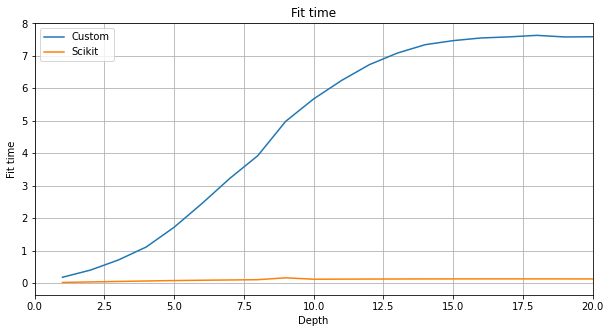

In [52]:
plot_measure(measures, 'fit', 'Fit time')

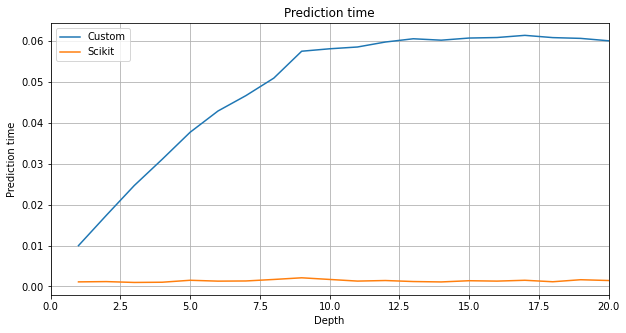

In [53]:
plot_measure(measures, 'predict', 'Prediction time')

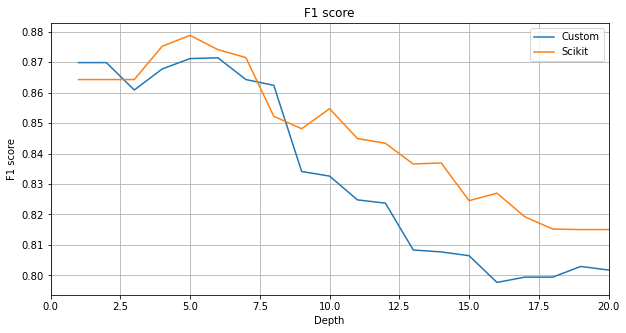

In [54]:
plot_measure(measures, 'f1', 'F1 score')

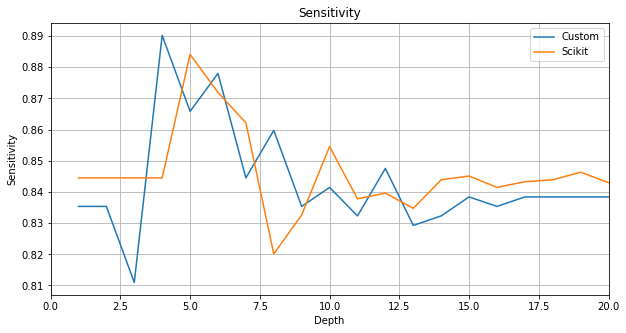

In [55]:
plot_measure(measures, 'sens', 'Sensitivity')

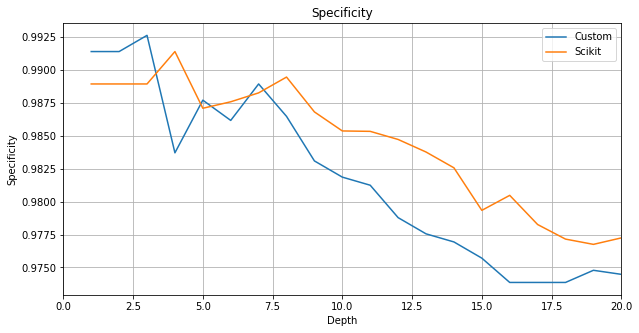

In [56]:
plot_measure(measures, 'spec', 'Specificity')

Wybierając cel dla pierwszej sądy mającej zbadać pulsar z bliska poszukiwanie optymalnej głębokości nie jest uzasadnione. Drzewo powinno mieć nieskończoną głębokość, ponieważ czas nauki i tak będzie mniejszy od czasu lotu sądy.